Simple gradient-based quadratic classification model to compute $W$. 

In [1]:
# ! pip install torch scikit-learn matplotlib -q

In [2]:
import sys
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
from pathlib import Path

sys.path.append("..")

from src.models.trainer import create_model_and_trainer
from src.config.config import cfg
from src.viz.model_viz import plot_model_performance, plot_feature_importance, plot_ranked_feature_importance, plot_sample_predictions, display_final_metrics
from src.data.preprocessing import load_and_preprocess_data

np.set_printoptions(precision=2, suppress=True, linewidth=120)


In [3]:

hyp = {
    "data_paths": [
        "../data/encoded/S21_encoded_with_outcomes.csv",
        "../data/encoded/W21_encoded_with_outcomes.csv",
        "../data/encoded/S17_encoded_with_outcomes.csv",
        "../data/encoded/W17_encoded_with_outcomes.csv",
        "../data/encoded/top_companies_encoded_with_outcomes.csv"
    ],
    "synthetic_data_path": '../data/synth/encoded_founders_composites.csv',
    "test_size": 0.1,
    "val_size": 0.1,
    "random_state": 42,
    "batch_size": 64,
    "lr": 0.0001,
    "weight_decay": 1e-5,
    "epochs": 1000,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "exclude_columns": ["success", "exit_value", "funding_amount", "batch"],
    "target_column": "success",
    "diag_penalty": 0.005,
    "l1_penalty": 0.0005,
    "top_k_penalty": 0.005,
    "top_k": 10,
    "log_every": 5
    
}


Data Split Summary:
Real data: 1386 samples
Synthetic data: 1000 samples

Train set: 2122 samples (1122 real, 1000 synthetic)
Val set: 125 samples (all real)
Test set: 139 samples (all real)

Class distribution:
Train set - Real: 408/1122 positive
Train set - Synthetic: 577/1000 positive
Val set: 46/125 positive
Test set: 51/139 positive
Starting training...
Epoch Train Loss   Val Loss  Test Loss Train Acc   Val Acc  Test Acc  Val AUC Test AUC Val NDCG Test NDCG      P@K
------------------------------------------------------------------------------------------------------------------------
    0    47.1782    40.5899    45.7600    0.4642    0.3680    0.3669   0.5000   0.5000   0.7536   0.7066   0.4000
    5    45.9063    39.1302    44.2845    0.4642    0.3680    0.3669   0.5000   0.5000   0.7536   0.7066   0.4000
   10    44.8751    38.0165    43.1366    0.4642    0.3680    0.3669   0.5000   0.5000   0.7536   0.7066   0.4000
   15    43.9478    37.0091    42.0961    0.4642    0.3680  

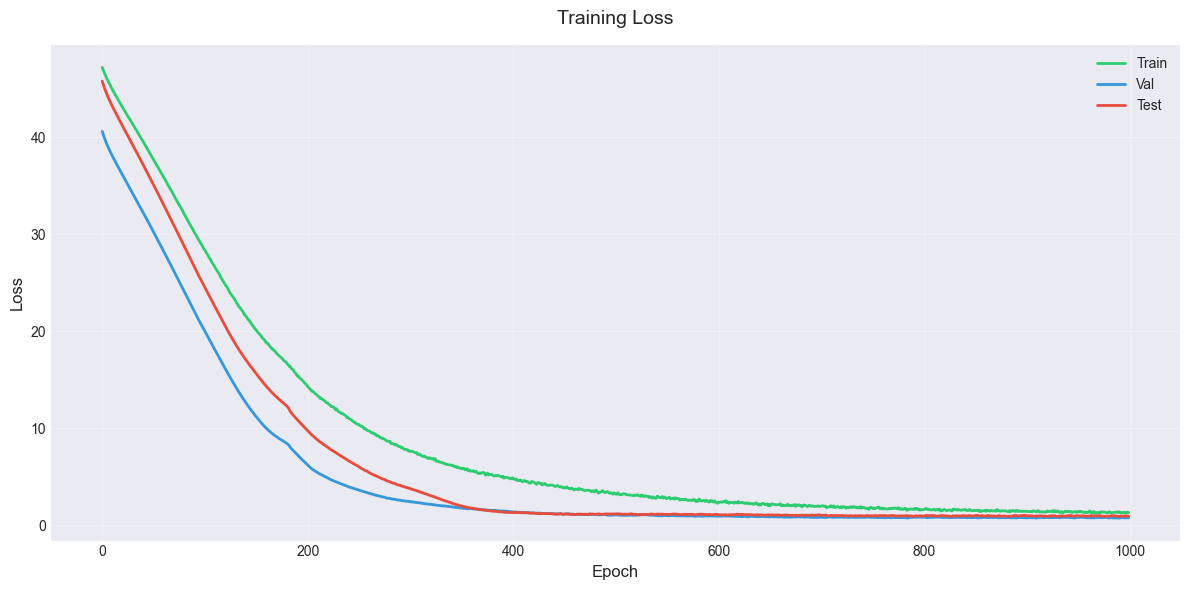

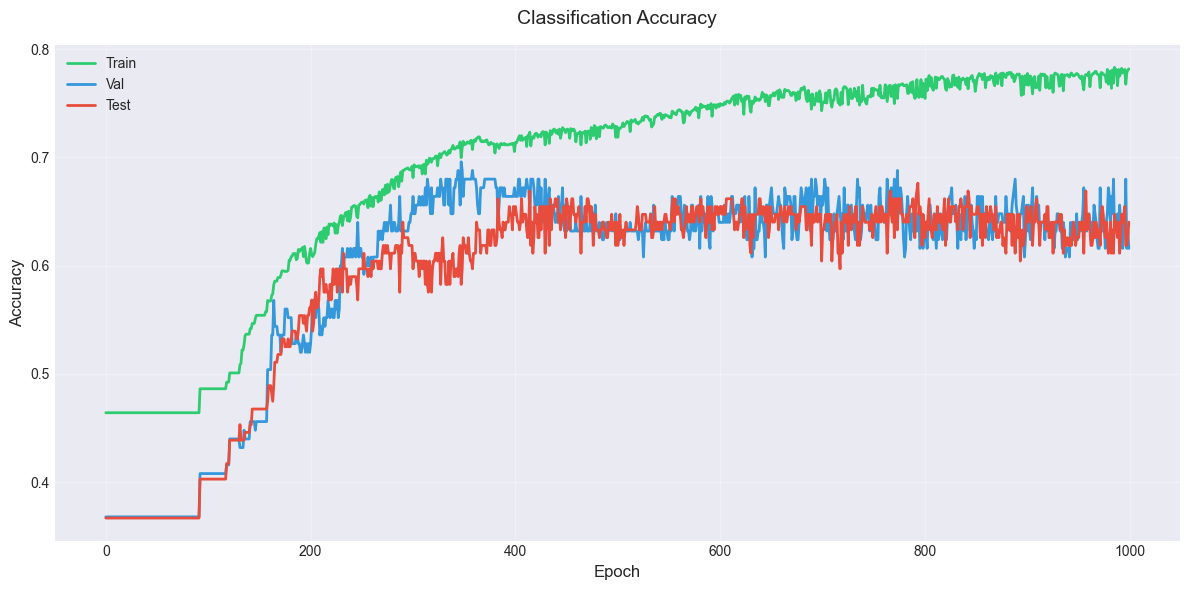

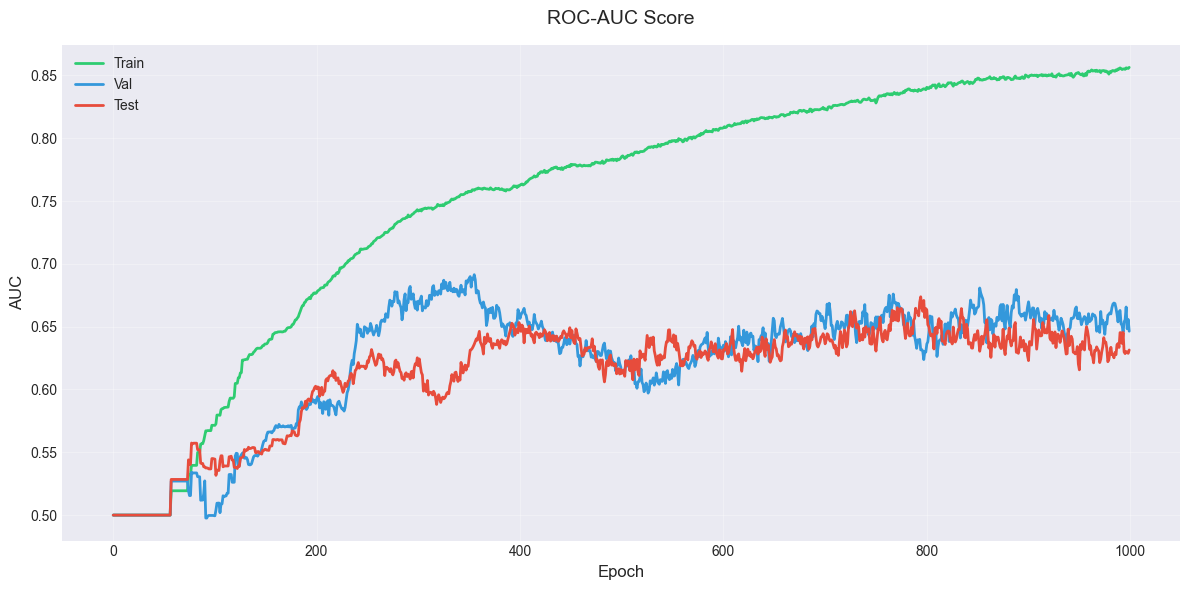

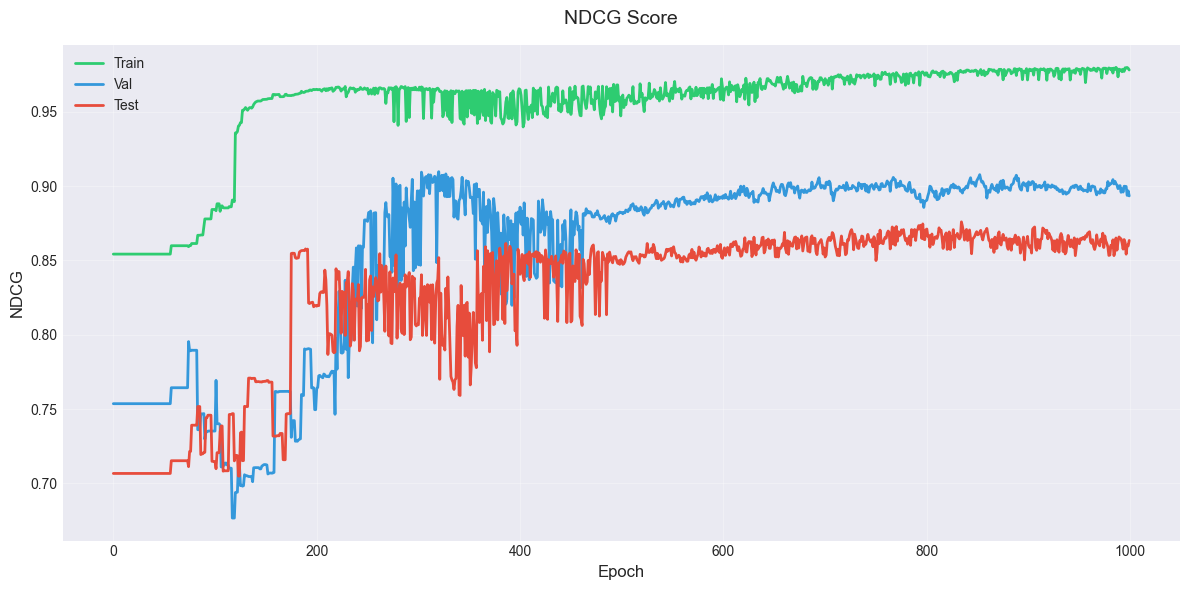

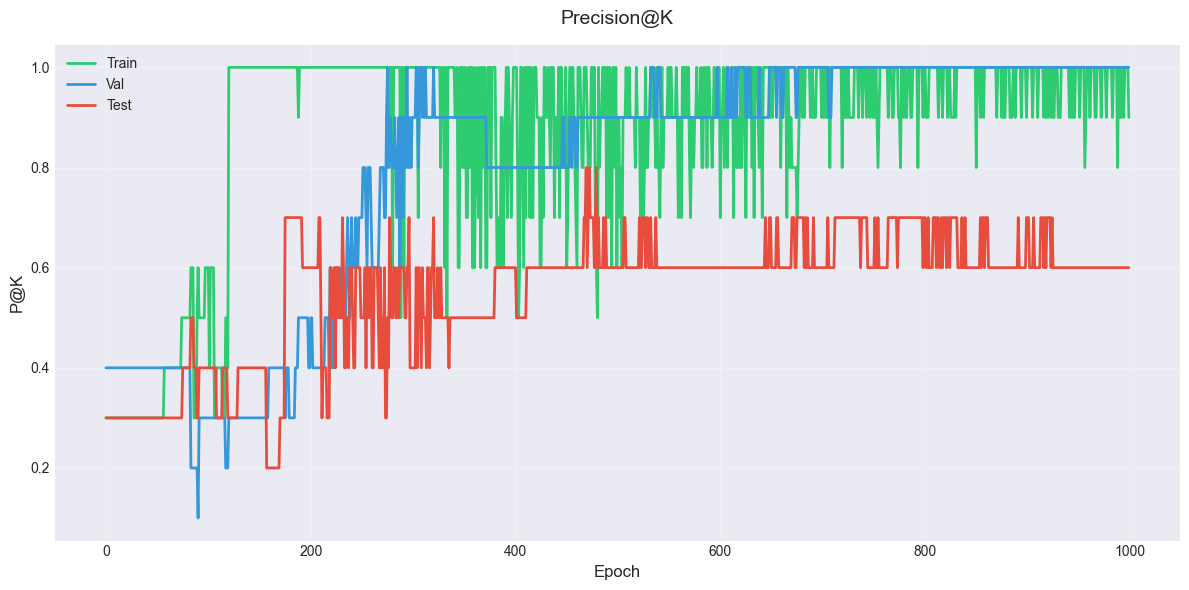

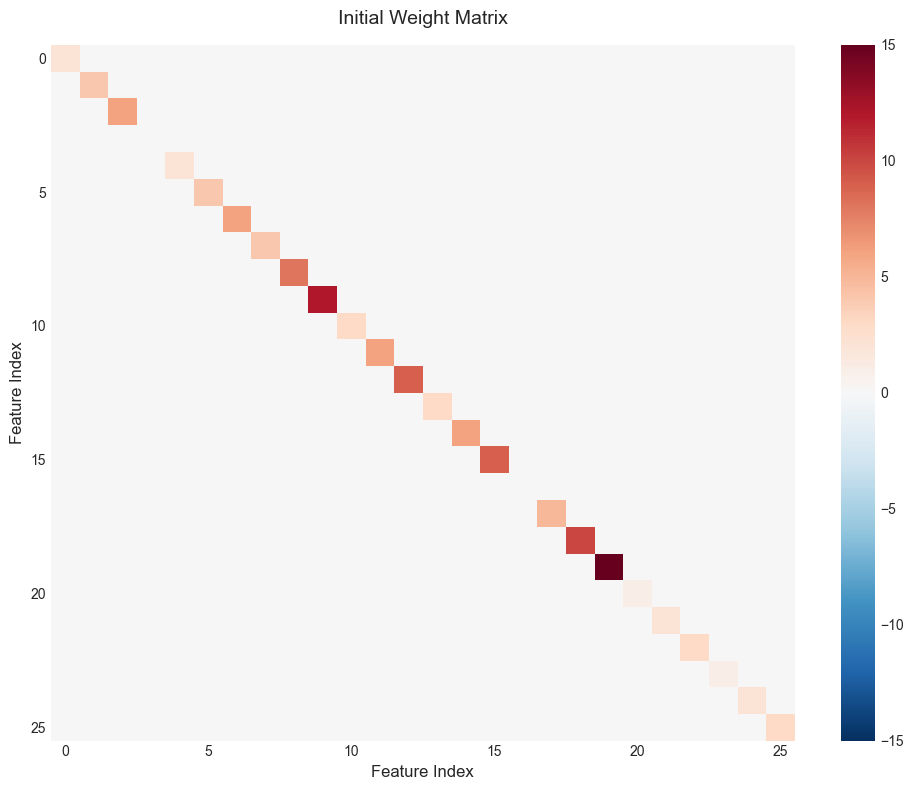

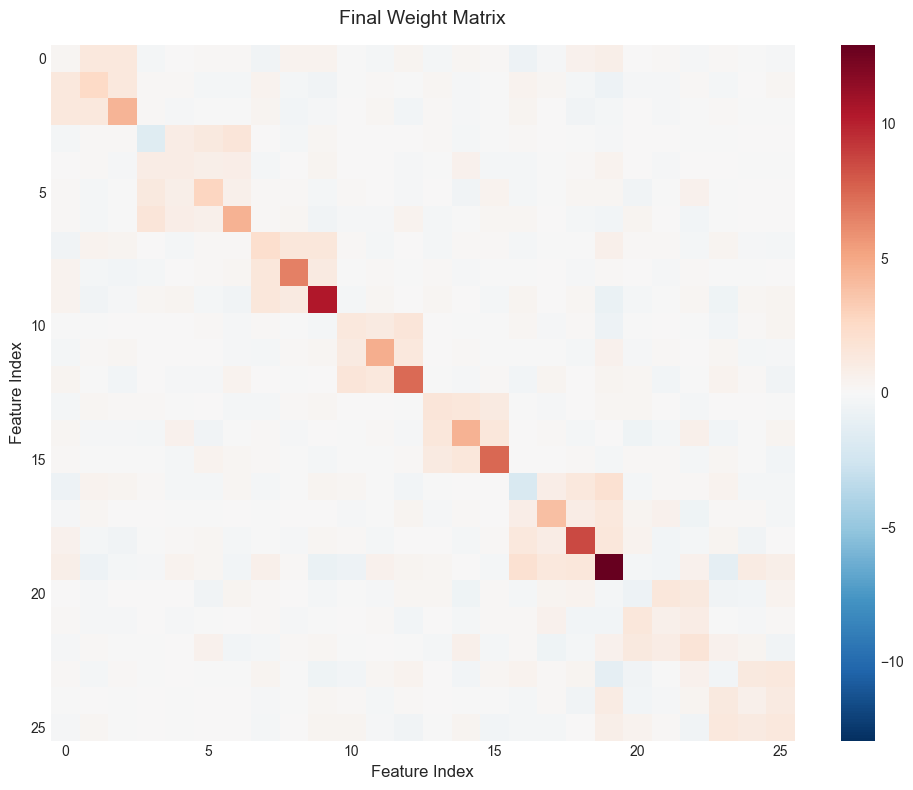

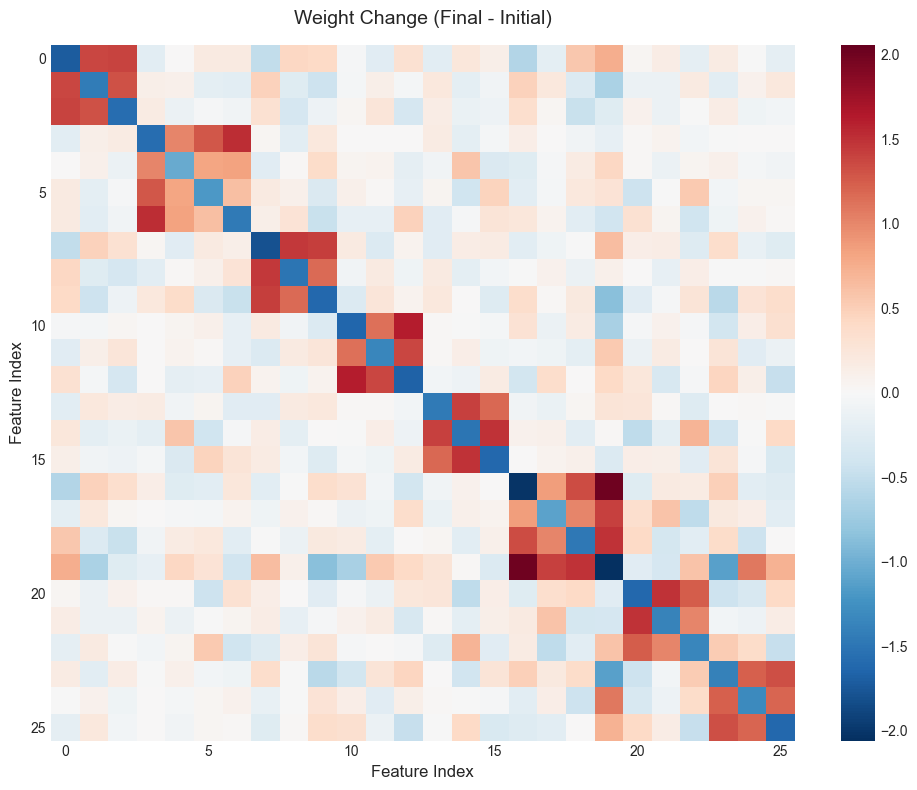

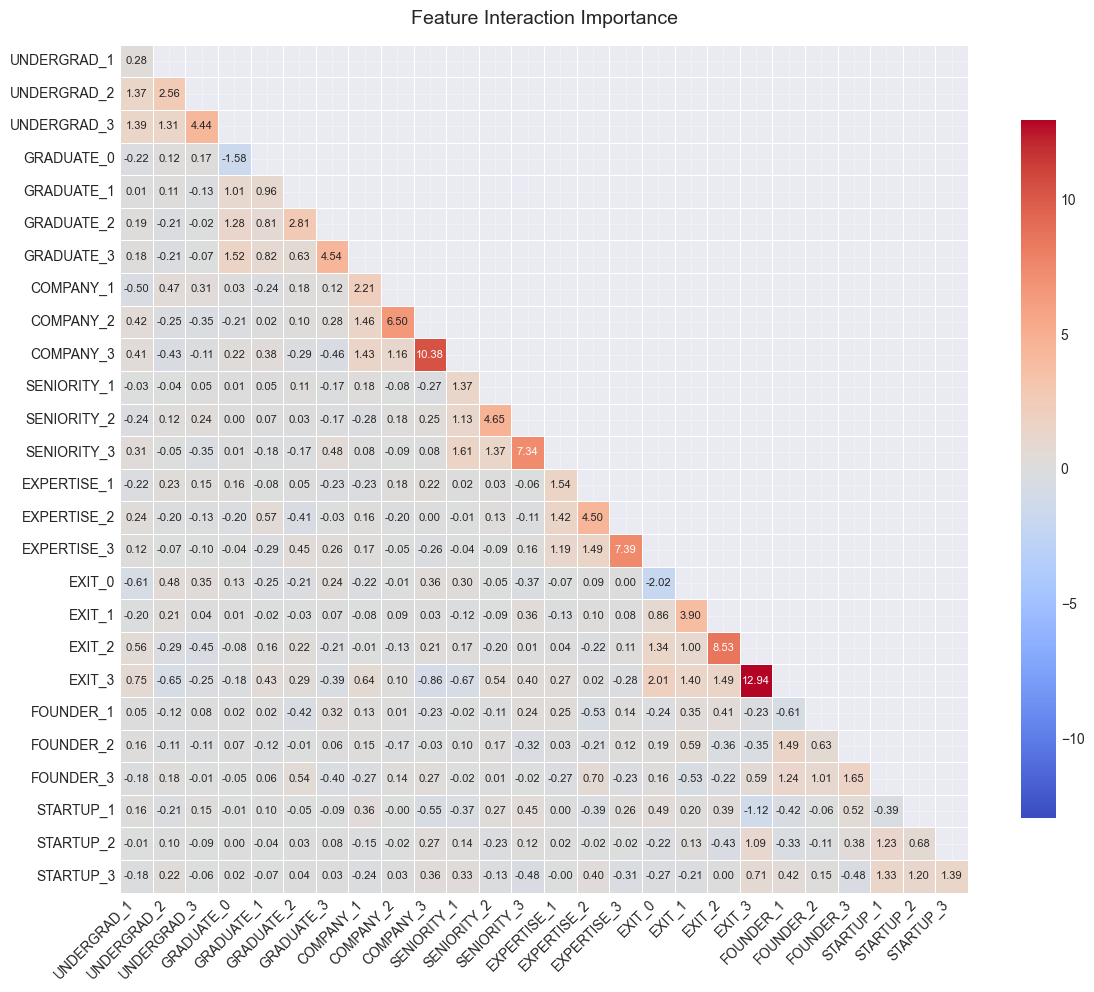

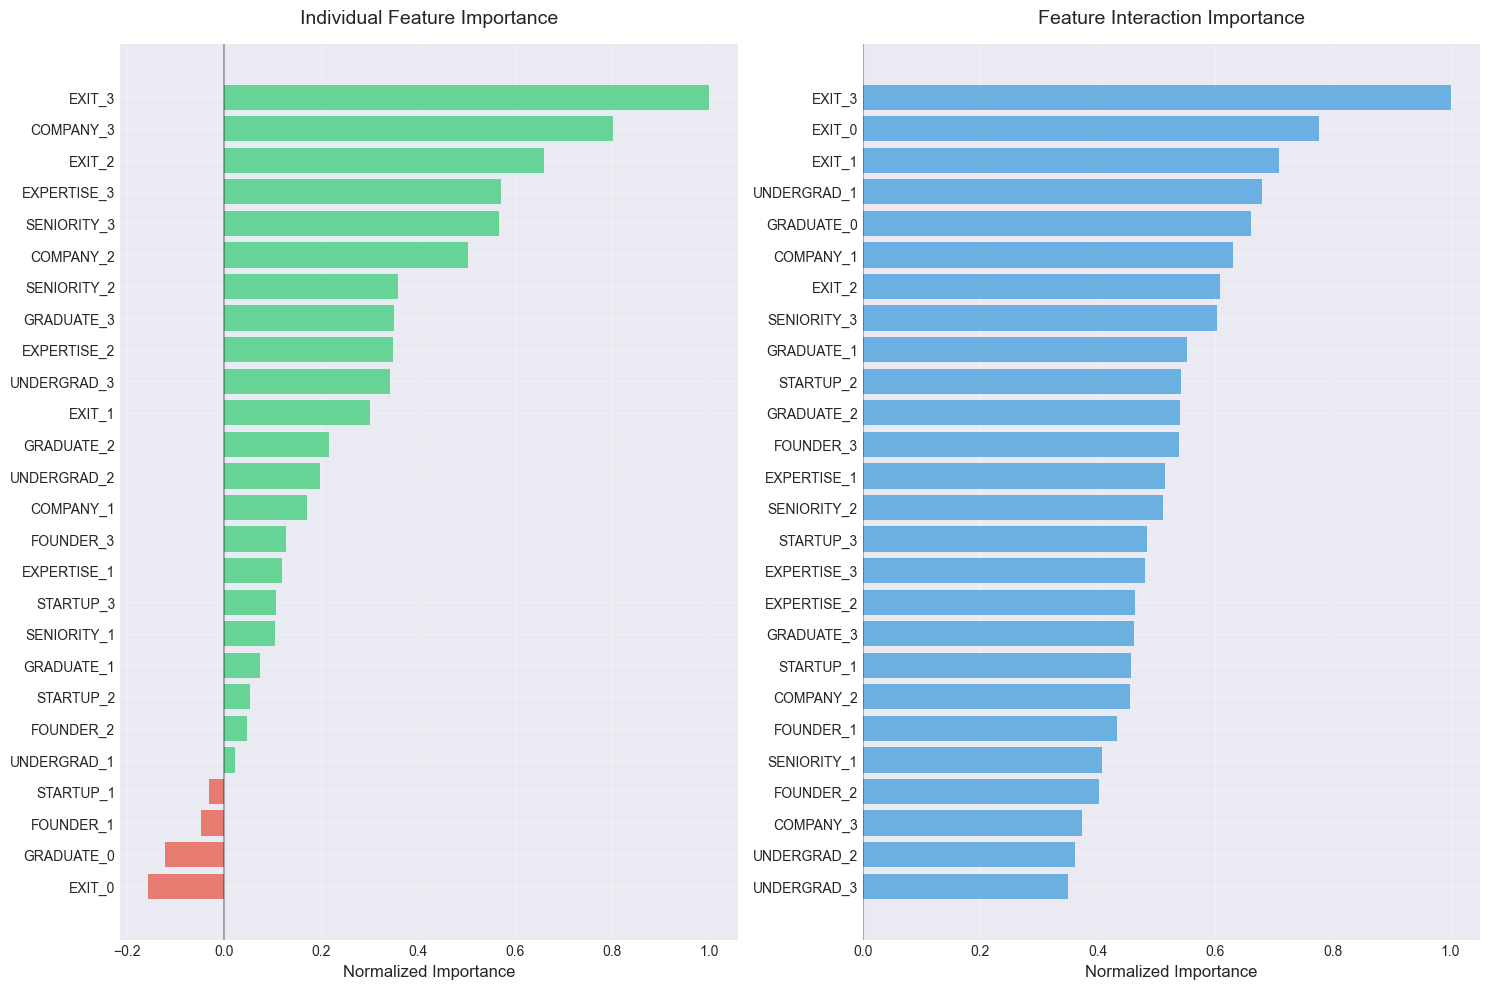

/Users/Viresh/Desktop/Spring 2025/Angel Network/founder-rank/notebooks/../src/viz/model_viz.py:303: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


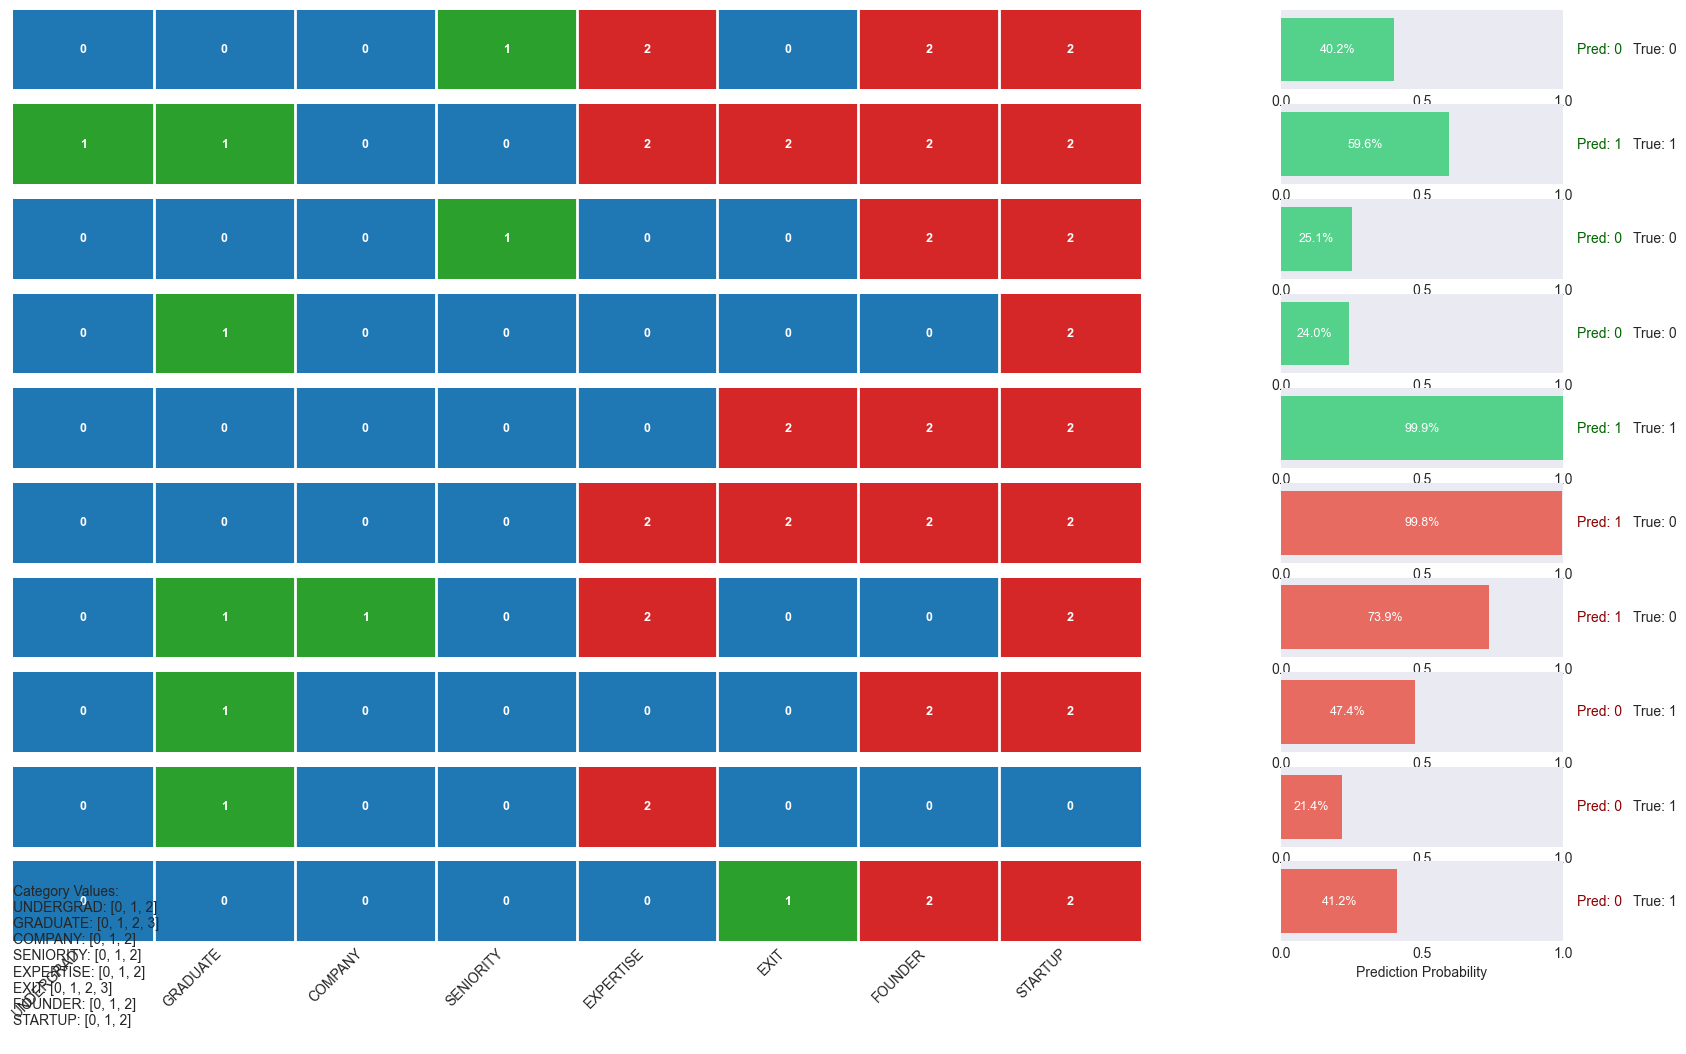

<Figure size 1200x600 with 0 Axes>

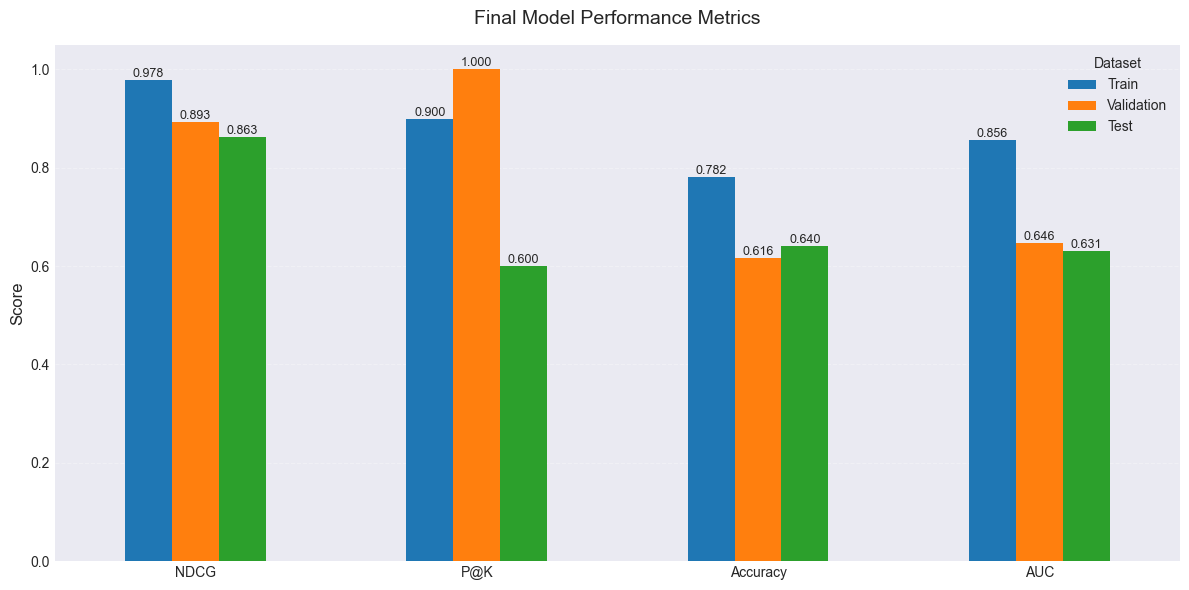


TRAIN SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81      1137
         1.0       0.81      0.70      0.75       985

    accuracy                           0.78      2122
   macro avg       0.79      0.78      0.78      2122
weighted avg       0.78      0.78      0.78      2122


VALIDATION SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.67      0.76      0.71        79
         1.0       0.47      0.37      0.41        46

    accuracy                           0.62       125
   macro avg       0.57      0.56      0.56       125
weighted avg       0.60      0.62      0.60       125


TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.68      0.82      0.74        88
         1.0       0.52      0.33      0.40        51

    accuracy                           0.64       139
   macro avg       0.60  

In [ ]:
tensors, feature_names, scaler = load_and_preprocess_data(hyp)

X_train_tensor, y_train_tensor, is_synthetic_train_tensor = tensors['train']
X_val_tensor, y_val_tensor = tensors['val']
X_test_tensor, y_test_tensor = tensors['test']

n_neg = (y_train_tensor == 0).sum()
n_pos = (y_train_tensor == 1).sum()
pos_weight = torch.tensor([n_neg / n_pos])

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, is_synthetic_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=hyp["batch_size"], shuffle=True)

input_dim = X_train_tensor.shape[1]
model, trainer = create_model_and_trainer(input_dim, hyp, pos_weight)

W_init = trainer.train_with_test_tracking(
    train_loader, 
    X_val_tensor, y_val_tensor, 
    X_test_tensor, y_test_tensor
)

W_final = model.get_W().detach().cpu().numpy()

predictions = trainer.predict(X_train_tensor, X_val_tensor, X_test_tensor)
train_probs, train_preds = predictions['train']
val_probs, val_preds = predictions['val'] 
test_probs, test_preds = predictions['test']

plot_model_performance(trainer, W_init)
plot_feature_importance(W_final, feature_names)
plot_ranked_feature_importance(W_final, feature_names)
plot_sample_predictions(model, X_test_tensor.numpy(), y_test_tensor.numpy(), cfg.MATRIX, scaler, n_samples=10, device=hyp['device'])

display_final_metrics(trainer)

print("\n" + "="*80)
print("TRAIN SET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_train_tensor.cpu().numpy(), train_preds, zero_division=0))

print("\n" + "="*80)
print("VALIDATION SET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_val_tensor.cpu().numpy(), val_preds, zero_division=0))

print("\n" + "="*80)
print("TEST SET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_tensor.cpu().numpy(), test_preds, zero_division=0))

model_dir = Path("../models")
model_dir.mkdir(exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'W_init': W_init,
    'W_final': model.get_W().detach().cpu().numpy(),
    'feature_names': feature_names,
    'scaler_state': scaler.__getstate__()
}, model_dir / "founder_rank.pt")
